C:\Users\dadia\AppData\Local\Temp\ipykernel_9848\3465026109.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Sample data:
   instructor_id    instructor_name  course_id course_name  semester_id  \
0              4       Steven Gomez          1    Course 1            1   
1              2  Frederick Stevens          1    Course 1            2   
2              3       Denise Fritz          1    Course 1            3   
3              4       Steven Gomez          2    Course 2            1   
4              5  Jonathon Gonzalez          2    Course 2            2   

  semester_name difficulty_level  avg_grade  avg_attendance  \
0    Semester 1             Easy  70.216216       74.270270   
1    Semester 2             Easy  69.588235       72.647059   
2    Semester 3             Easy  62.750000       68.750000   
3    Semester 1           Medium  70.815789       72.842105   
4    Semester 2           Medium  68.923077       75.051282   

   avg_assessment_score  
0             68.378378  
1             71.862745  
2             65.645833  
3             67.429825  
4             68.846154  



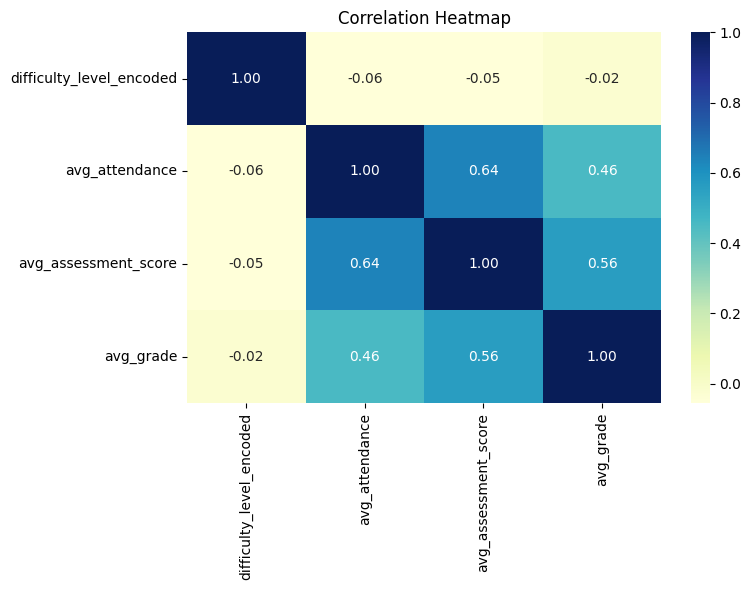

In [1]:
import pandas as pd
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# --- Database connection ---
conn = psycopg2.connect(
    dbname="final_db",
    user="postgres",
    password="admin",
    host="localhost",
    port="5432"
)

# --- Query instructor-course performance ---
query = """
SELECT 
  ci.instructor_id,
  i.instructor_name,
  c.course_id,
  c.course_name,
  ci.semester_id,
  sem.semester_name,
  cd.difficulty_level,
  AVG(e.grade) AS avg_grade,
  AVG(att.attendance_percentage) AS avg_attendance,
  AVG(a.score) AS avg_assessment_score
FROM course_instructor ci
JOIN instructor i ON ci.instructor_id = i.instructor_id
JOIN course c ON ci.course_id = c.course_id
JOIN course_difficulty cd ON c.course_id = cd.course_id
JOIN semester sem ON sem.semester_id = ci.semester_id
JOIN enrollment e ON e.course_id = ci.course_id AND e.semester_id = ci.semester_id
LEFT JOIN attendance att ON att.enroll_id = e.enroll_id
LEFT JOIN assessment a ON a.enroll_id = e.enroll_id
GROUP BY 
  ci.instructor_id, i.instructor_name, 
  c.course_id, c.course_name, 
  ci.semester_id, sem.semester_name, 
  cd.difficulty_level;
"""

# --- Load data into DataFrame ---
df = pd.read_sql(query, conn)
conn.close()

print("Sample data:")
print(df.head())

# --- Encode difficulty level ---
df['difficulty_level_encoded'] = LabelEncoder().fit_transform(df['difficulty_level'])

# --- Define features and target ---
features = ['difficulty_level_encoded', 'avg_attendance', 'avg_assessment_score']
target = 'avg_grade'

X = df[features]
y = df[target]

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model (XGBoost) ---
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# --- Save model ---
with open("../final_app/models/instructor_course_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("\nModel saved as 'instructor_course_model.pkl'")

# --- Export data to CSV ---
df.to_csv("../data/instructor_course_performance.csv", index=False)
print("Data saved to 'instructor_course_performance.csv'")

# --- Correlation heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()